# **Using GANs to generate handwritten digits**

To generate images of handwritten digits, we will leverage the same network as we
learned about in the previous section. The strategy we will adopt is as follows:
1. Import MNIST data.
2. Initialize random noise.
3. Define the generator model.
4. Define the discriminator model.
5. Train the two models alternately.
6. Let the model train until the generator and discriminator losses are largely
the same.

<img src="GAN_1.png" width=600 height=700 />

In [1]:
!pip install jsonlines

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
!pip install -q torch_snippets
import torch.utils.data
from torch_snippets import *

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision import transforms

Import the MNIST data and define the dataloader with built-in data
transformation so that the input data is scaled to a mean of 0.5 and a
standard deviation of 0.5:

In [4]:
! pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_loader = datasets.MNIST(root='/content', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(train_loader, batch_size=32, shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



# *Define the Discriminator model class:*

In [6]:
# TODO: Define the Discriminator model class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(nn.Linear(784, 1024),
                                   nn.LeakyReLU(0.2),
                                   nn.Dropout(0.3),
                                   nn.Linear(1024, 512),
                                   nn.LeakyReLU(0.2),
                                   nn.Dropout(0.3),
                                   nn.Linear(512, 256),
                                   nn.LeakyReLU(0.2),
                                   nn.Dropout(0.2),
                                   nn.Linear(256, 1),
                                   nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

>  **`Leaky Rectified Linear Unit`**, or Leaky ReLU, is a type of activation function based on a ReLU, but it has a small slope
 for negative values instead of a flat slope. ... This type of activation function is popular in tasks where we we may
 suffer from sparse gradients, for example training generative adversarial networks.

In [7]:
! pip install torch_summary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [13]:
discriminator = Discriminator().to(device)
summary(discriminator, torch.zeros(1, 784));  # This is a summary of discriminator

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 1024]                803,840
|    └─LeakyReLU: 2-2                    [-1, 1024]                --
|    └─Dropout: 2-3                      [-1, 1024]                --
|    └─Linear: 2-4                       [-1, 512]                 524,800
|    └─LeakyReLU: 2-5                    [-1, 512]                 --
|    └─Dropout: 2-6                      [-1, 512]                 --
|    └─Linear: 2-7                       [-1, 256]                 131,328
|    └─LeakyReLU: 2-8                    [-1, 256]                 --
|    └─Dropout: 2-9                      [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 1]                   257
|    └─Sigmoid: 2-11                     [-1, 1]                   --
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable par

# *Define the Generator model class:*

In [14]:
# TODO: Define the generator model class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(nn.Linear(100, 256),
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(256, 512),
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(512, 1024),
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(1024, 784),
                                   nn.Tanh())

    def forward(self, x):
        return self.model(x)



> Note that the generator takes a 100-dimensional input (which is of random
noise) and generates an image from the input. A summary of the generator
model is as follows:

In [15]:
generator = Generator().to(device)
summary(generator, torch.zeros(1, 100));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 784]                 --
|    └─Linear: 2-1                       [-1, 256]                 25,856
|    └─LeakyReLU: 2-2                    [-1, 256]                 --
|    └─Linear: 2-3                       [-1, 512]                 131,584
|    └─LeakyReLU: 2-4                    [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 1024]                525,312
|    └─LeakyReLU: 2-6                    [-1, 1024]                --
|    └─Linear: 2-7                       [-1, 784]                 803,600
|    └─Tanh: 2-8                         [-1, 784]                 --
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
Total mult-adds (M): 2.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.67
Estimated Total Size (MB): 5.69


Define a function to generate random noise and register it to the device:

In [16]:
def noise(size):
    n = torch.randn(size, 100)
    return n.to(device)


## *`Define a function to train the discriminator`*

The discriminator training function (discriminator_train_step)
takes real data (real_data) and fake data (fake_data) as input:

In [17]:
# TODO: Define a function to train the discriminator
def discriminator_train_step(real_data, fake_data):
    # Reset the gradient
    d_optimizer.zero_grad()

    # Predict on the real data
    prediction_real_data = discriminator(real_data)

    # Calculate the loss
    real_loss = loss(prediction_real_data, torch.ones(len(real_data), 1).to(device))
    real_loss.backward()

    # Predict on the fake data
    prediction_fake_data = discriminator(fake_data)

    # Calculate the loss
    fake_loss = loss(prediction_fake_data, torch.zeros(len(fake_data), 1).to(device))
    fake_loss.backward()

    # Update weights
    d_optimizer.step()

    return real_loss + fake_loss

> When we calculate the discriminator loss on real data, we expect the
discriminator to predict an output of 1. Hence, the discriminator loss
on real data is calculated by expecting the discriminator to predict
output as 1 using **`torch.ones`** during discriminator training.

> When we calculate the discriminator loss on fake data, we expect the
discriminator to predict an output of 0. Hence, the discriminator loss
on fake data is calculated by expecting the discriminator to predict
output as 0 using **`torch.zeros`** during discriminator training.

## *`Train the generator model`*

In [18]:
# TODO: Train the generator model
def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction, torch.ones(len(fake_data), 1).to(device))
    error.backward()
    g_optimizer.step()

    return error

**TODO: Define the model objects, the optimizer for each generator and discriminator, and the loss function to optimize**

In [20]:
# TODO: Define the model objects, the optimizer for each generator and discriminator, and the loss function to optimize
discriminator = Discriminator().to(device)
generator = Generator().to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()
num_epochs = 200
log = Report(num_epochs)

## **`Run the models over increasing epochs:`**

EPOCH: 1.000	d_loss: 1.097	g_loss: 1.909	(267.36s - 53204.73s remaining))))
EPOCH: 2.000	d_loss: 0.958	g_loss: 1.575	(318.13s - 31495.06s remaining)
EPOCH: 3.000	d_loss: 0.747	g_loss: 1.789	(363.87s - 23894.34s remaining)
EPOCH: 4.000	d_loss: 0.825	g_loss: 1.755	(408.83s - 20032.79s remaining)
EPOCH: 5.000	d_loss: 0.878	g_loss: 1.584	(453.06s - 17669.46s remaining)
EPOCH: 6.000	d_loss: 0.954	g_loss: 1.459	(498.69s - 16124.18s remaining)
EPOCH: 7.000	d_loss: 0.992	g_loss: 1.368	(541.63s - 14933.60s remaining)
EPOCH: 8.000	d_loss: 1.057	g_loss: 1.271	(585.31s - 14047.44s remaining)
EPOCH: 9.000	d_loss: 1.060	g_loss: 1.249	(621.44s - 13188.37s remaining)
EPOCH: 10.000	d_loss: 1.068	g_loss: 1.241	(663.18s - 12600.35s remaining)
EPOCH: 11.000	d_loss: 1.072	g_loss: 1.233	(706.77s - 12143.67s remaining)
EPOCH: 12.000	d_loss: 1.098	g_loss: 1.190	(751.79s - 11778.06s remaining)
EPOCH: 13.000	d_loss: 1.106	g_loss: 1.182	(799.01s - 11493.41s remaining)
EPOCH: 14.000	d_loss: 1.135	g_loss: 1.122	(8

100%|██████████| 301/301 [00:35<00:00,  8.46it/s]


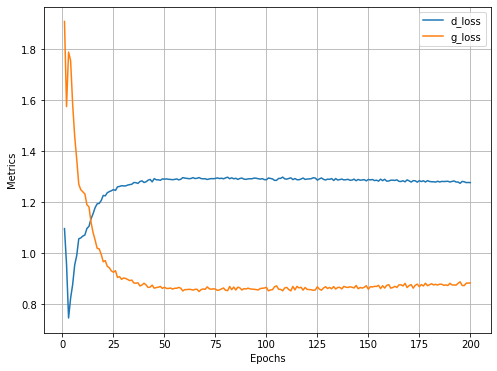

In [22]:
# TODO: Run the models over increasing epochs:
for epoch in range(num_epochs):
    N = len(data_loader)
    for i, (images, _) in enumerate(data_loader):
        real_data = images.view(len(images), -1).to(device)
        fake_data = generator(noise(len(real_data))).to(device)
        
        # On detaching, we are creating a fresh copy of the tensor 
        fake_data = fake_data.detach()

        # Train the discriminator using the discriminator_train_step
        d_loss = discriminator_train_step(real_data, fake_data)

        # Generate the fake data
        fake_data = generator(noise(len(real_data))).to(device)
        # Generate the fake image with fake data
        g_loss = generator_train_step(fake_data)

        # Record the losses
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')

    log.report_avgs(epoch+1)

# Plot the report
log.plot_epochs(['d_loss', 'g_loss'])

#### Preceding output, discriminator and generator losses over increasing epochs 

> **`NOTE`**: Load real data `(real_data)` and `fake data`, where fake data
(fake_data) is obtained by passing noise (with a batch size of the
number of data points in real_data – `len(real_data))` through the
generator network. Note that it is important to
run `fake_data.detach()`, or else training will not work. On
detaching, we are creating a fresh copy of the tensor so that when
`error.backward()` is called in `discriminator_train_step`, the
tensors associated with the generator (which create fake_data) are
not affected:

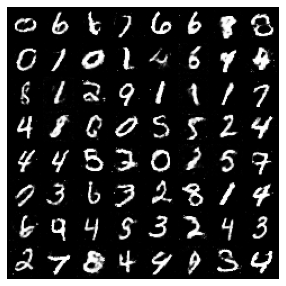

In [27]:
# TODO: Visualize the fake data post-training:
z = torch.randn(64, 100).to(device)
sample_images = generator(z).data.cpu().view(64, 1, 28, 28)
grid = make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1, 2, 0), sz=5)